In [1]:
import gensim
import os
import re
import numpy as np
import json as js
import argparse
import pandas as pd
import sklearn
import joblib
import torch
import matplotlib.pyplot as plt
import datasets
from datasets import Dataset, DatasetDict
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from gensim.models import KeyedVectors
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer



In [26]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")



In [3]:
def BERTvectorizer(token):
    model = BertModel.from_pretrained("bert-base-uncased")

    encoded_input = []
    encoded_input = token
    if encoded_input.size(1)>512:
        half_size=encoded_input.size(1)//2
        encoded_input1=encoded_input[:,half_size:]
        encoded_input2=encoded_input[:,:half_size]
        output1=model(encoded_input1)
        output2=model(encoded_input2)
        pooler_vector1 = output1.pooler_output
        pooler_vector_np1 = pooler_vector1.detach().numpy()
        pooler_vector2 = output2.pooler_output
        pooler_vector_np2 = pooler_vector2.detach().numpy()
        pooler_vector_np = (pooler_vector1 + pooler_vector2)/2
    
    else: 
        output = model(encoded_input)
        pooler_vector = output.pooler_output
        pooler_vector_np = pooler_vector.detach().numpy()
        return pooler_vector_np[0]
    

In [4]:
def getPooler_vector(output):
    pooler_vector = []
    pooler_vector = output.pooler_output
    pooler_vector_np = pooler_vector.detach().numpy()
    return pooler_vector_np[0]
    

In [5]:
def getBERT_pooler_vector(tensor,model):
    output=model(tensor)
    pooler_vector = []
    pooler_vector = output.pooler_output
    pooler_vector_np = pooler_vector.detach().numpy()
    return pooler_vector_np[0]
    

In [6]:
def getDataJSON(route):
    with open(route,"r",encoding="utf-8") as f:
        result = [js.loads(jline.replace("diff","value")) for jline in f.read().splitlines()]
    return result

In [7]:
def getSize(tensor):
    tensorSize = tensor.size(1)
    #if tensor.size(1)>512:
        #tensor=tensor[:,:512]
    return tensorSize

In [8]:
def downsize(tensor):
    tensorSize = tensor.size(1)
    if tensor.size(1)>512:
        tensor=tensor[:,:512]
    return tensor

In [9]:
def shortPandas(serie,n):
    serie_acortada=serie[:n]
    return serie_acortada

In [10]:
def funcToPandas(serie,fun):
    serie_final = pd.Series(dtype=object)
    for tensor in serie:
        serie_final = serie_final.concat(pd.Series(fun(tensor)))

    return serie_final

In [11]:
def specialTokens(text):
    text=text.strip()
    marked_text = "[CLS] " + text + " [SEP]"
    return marked_text

In [12]:
def seriesToDataset(ds):
    df=ds.to_frame()
    dataset = Dataset.from_pandas(df)
    return dataset

In [13]:
def tokenization(example,label):

    return tokenizer(example[label],padding=True, truncation=True, max_length=512,return_tensors="pt")

In [14]:
def tokenizeDataset(dataset,label):
    dataset = dataset.map(tokenization ,fn_kwargs={"label": label})
    dataset.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "id"])
    return dataset

In [33]:
def bertMapping(inputs):
    embedding = model(**inputs)
    return embedding.last_hidden_state[:,0,:]

In [34]:

def BERTProcessing(datadir,tokenizer,model):
    aux = os.path.join(datadir, "train.jsonl")
    data = pd.DataFrame(getDataJSON(aux)).set_index("id")
    data[['text1','text2']] = pd.DataFrame(data.pair.tolist(), index= data.index)

    aux = os.path.join(datadir, "train_truth.jsonl")

    del data["pair"]
    data2 = pd.DataFrame(getDataJSON(aux)).set_index("id")
    data = pd.merge(data,data2,how='outer',left_index=True,right_index=True)
    del data2

    n=700
    
    X_0 = data["text1"]
    X_0 = X_0.apply(specialTokens)
    X_0_dataset=seriesToDataset(X_0)
    X_0_dataset=tokenizeDataset(X_0_dataset,"text1")
    X_0_features=X_0_dataset.remove_columns(["id","text1"])
    X_0_features=X_0_features.map(bertMapping)

    X_1 = data["text2"]
    X_1 = X_1.apply(specialTokens)
    
 
    Y = data["value"]
    print("$$$$$$-DONE-$$$$$$")
    return X_0_features


In [35]:
data=BERTProcessing("../corpus/dataset1/train/prepared/",tokenizer,model)

Map:   0%|          | 0/12904 [00:00<?, ? examples/s]

Map:   0%|          | 0/12904 [00:00<?, ? examples/s]

TypeError: Provided `function` which is applied to all elements of table returns a variable of type <class 'torch.Tensor'>. Make sure provided `function` returns a variable of type `dict` (or a pyarrow table) to update the dataset or `None` if you are only interested in side effects.

In [36]:
model(**data[0]).last_hidden_state[:,0,:]

tensor([[ 3.0199e-01, -1.1003e-01, -5.8444e-01,  9.6410e-02, -3.7410e-01,
         -5.5397e-01,  5.6291e-01,  5.9127e-01, -1.5313e-01, -2.5664e-01,
          4.3681e-01, -2.9659e-02, -5.3467e-01,  1.6871e-01,  6.8346e-02,
          5.2782e-01,  1.3441e-01,  3.4588e-01,  5.0626e-01,  6.5366e-02,
         -6.1739e-01, -2.2042e-01,  4.6220e-01,  1.2357e-01, -6.3202e-02,
         -5.2010e-01,  1.8278e-01, -5.8763e-02, -5.2273e-01,  5.0406e-02,
         -9.5753e-02,  5.0033e-01, -3.2917e-01, -6.7212e-01,  2.5641e-01,
         -5.3866e-03, -2.2893e-02, -2.7633e-01,  3.0336e-01, -1.2384e-01,
         -4.5536e-01,  2.5108e-01,  1.0957e-01, -4.5341e-02, -1.2632e-01,
         -2.9062e-01, -4.6371e+00,  1.7844e-02,  1.4872e-01, -2.1833e-01,
         -1.1564e-01, -3.9725e-01, -3.1603e-01,  5.2734e-01,  6.4705e-01,
          1.8185e-01, -5.3024e-01,  1.7718e-01,  2.6893e-04, -1.5319e-01,
         -5.4272e-02,  2.8582e-01, -1.0580e-01, -2.4973e-01, -1.5196e-01,
          6.2577e-01,  3.4010e-01,  4.

In [181]:
model(**newdata[0])

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.3020, -0.1100, -0.5844,  ..., -0.0246,  0.5016,  0.8625],
         [ 0.3164, -0.1270, -0.5607,  ..., -0.0151,  0.5435,  0.8342],
         [ 0.2181, -0.1588,  0.0582,  ...,  0.6549,  0.6297,  0.2814],
         ...,
         [ 0.0256, -0.8877, -0.1348,  ...,  0.2767,  0.5419, -0.4608],
         [ 0.2031,  0.1048, -0.0921,  ...,  0.5314, -0.2333,  0.0164],
         [ 0.2082,  0.1178, -0.0670,  ...,  0.5220, -0.2341,  0.0020]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-7.1382e-01, -6.3166e-01, -9.9564e-01,  7.2754e-01,  9.4202e-01,
         -3.6799e-01,  3.0951e-01,  3.9552e-01, -9.6167e-01, -9.9997e-01,
         -7.3551e-01,  9.6921e-01,  9.6494e-01,  9.1346e-01,  6.9288e-01,
         -6.5524e-01, -1.9906e-01, -6.1654e-01,  2.5784e-01,  7.9551e-01,
          6.1059e-01,  1.0000e+00, -5.3441e-01,  4.4122e-01,  5.8368e-01,
          9.9086e-01, -7.5463e-01,  8.3391e-01,  8.9211e-01,  6.542

In [173]:

def plot_points_with_labels(vectors_df, labels_df):
  # Asegúrate de que las etiquetas y los vectores tengan el mismo índice
    labels_df.to_frame()
  # Separa los vectores según las etiquetas
    vectors_label_0 = vectors_df[labels_df == 0]
    vectors_label_1 = vectors_df[labels_df == 1]
    
  # Crea un gráfico de puntos
    plt.figure(figsize=(8, 6))
    plt.scatter(vectors_label_1.iloc[:, 0], vectors_label_1.iloc[:, 1], color='red', label='Con cambio')
    plt.scatter(vectors_label_0.iloc[:, 0], vectors_label_0.iloc[:, 1], color='blue', label='Sin cambio')
    
    
  # Configura las etiquetas y el título
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Embeddings Isomap')
   
  # Muestra la leyenda
    plt.legend()
   
  # Muestra el gráfico
    plt.show()

In [27]:
def redimensionarPCA(X):
    pca = PCA(n_components=2)
    X_vectores = X.apply(pd.Series)
    pca.fit(X_vectores.T)
    X_PCAvec = pd.DataFrame(pca.components_.T,index=X_vectores.index)
    return X_PCAvec


In [30]:
import matplotlib.pyplot as plt

/tmp/ipykernel_15354/4209396840.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vectors_label_0 = vectors_df[labels_df == 0]
/tmp/ipykernel_15354/4209396840.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vectors_label_1 = vectors_df[labels_df == 1]


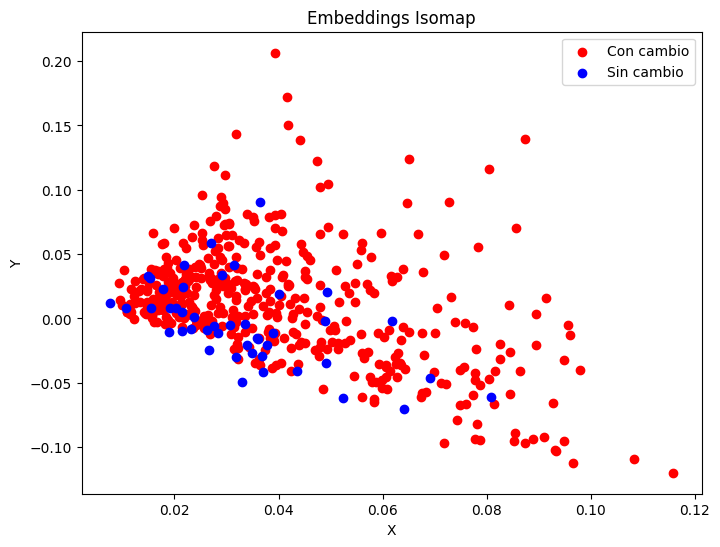

In [31]:
X_1=redimensionarPCA(data[0])
plot_points_with_labels(X_1,data[1])

In [32]:
def redimensionarTSNE(X):
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
    X_vectores = X.apply(pd.Series)
    X_vec = tsne.fit_transform(X_vectores)
    X_TSNEvec = pd.DataFrame(X_vec,index=X_vectores.index)
    print(X_TSNEvec)
    return X_TSNEvec

In [33]:
def redimensionarISOMAP(X):
    isomap=Isomap(n_components=2)
    X_vectores = X.apply(pd.Series)
    X_vec = isomap.fit_transform(X_vectores)
    X_ISOMAPvec = pd.DataFrame(X_vec,index=X_vectores.index)
    print(X_ISOMAPvec)
    return X_ISOMAPvec

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 1.191441
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.238262
[t-SNE] KL divergence after 1000 iterations: 0.872929
                  0          1
id                            
1-1-2    -14.796653   5.952022
1-2-3      4.677359   9.719782
10-1-2     6.885386   4.889726
10-2-3    -6.766318   4.514328
10-3-4     6.376362 -12.339467
...             ...        ...
1141-3-4   3.144313  -7.798896
1141-4-5  -8.857831   9.571901
1141-5-6  -2.474102  10.852921
1142-1-2   9.977493   1.332038
1142-2-3 -13.318863   4.923319

[500 rows x 2 columns]


/tmp/ipykernel_15354/4209396840.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vectors_label_0 = vectors_df[labels_df == 0]
/tmp/ipykernel_15354/4209396840.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vectors_label_1 = vectors_df[labels_df == 1]


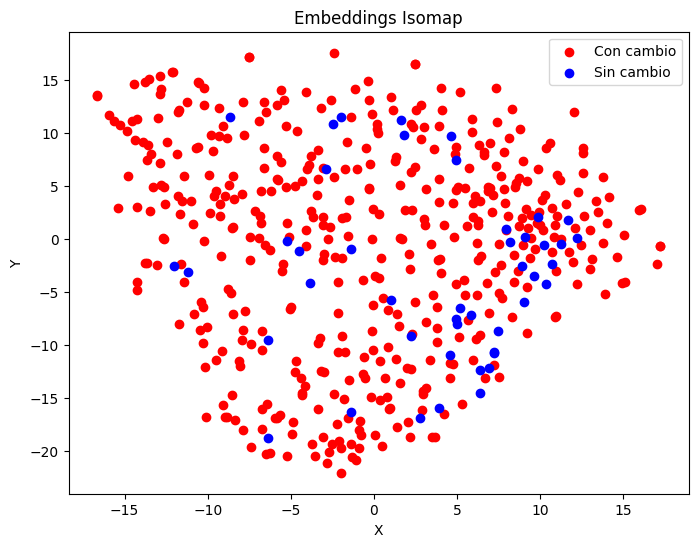

In [34]:
X_2=redimencionarTSNE(data[0])
plot_points_with_labels(X_2,data[1])

                 0         1
id                          
1-1-2    -9.382135  7.011073
1-2-3    -2.660805 -5.443296
10-1-2   -0.983438 -4.709499
10-2-3   -3.630899  2.284016
10-3-4    6.925747 -2.370372
...            ...       ...
1141-3-4  3.599277 -0.999538
1141-4-5 -8.960021  1.829187
1141-5-6 -5.530861 -0.930918
1142-1-2  0.673406 -5.336154
1142-2-3 -8.613990 -1.375538

[500 rows x 2 columns]


/tmp/ipykernel_15354/4209396840.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vectors_label_0 = vectors_df[labels_df == 0]
/tmp/ipykernel_15354/4209396840.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vectors_label_1 = vectors_df[labels_df == 1]


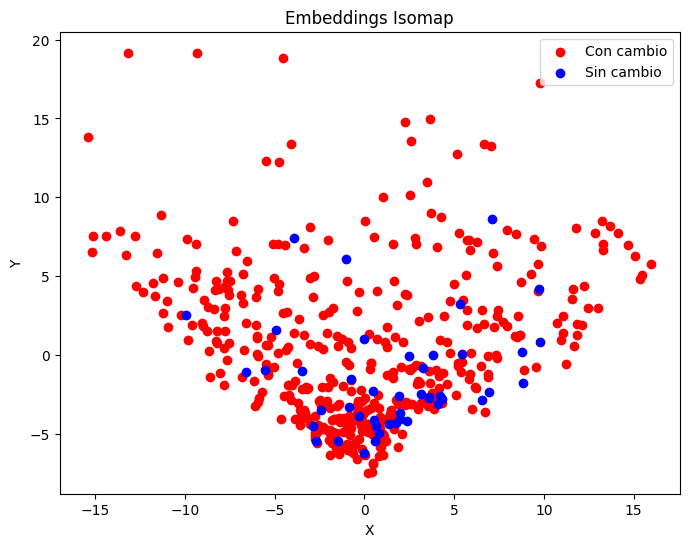

In [36]:
X_3=redimensionarISOMAP(data[0])
plot_points_with_labels(X_3,data[1])